In [118]:
import pandas as pd
import seaborn as sns 
from pandas import DataFrame
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import numpy as np
import plotly
import statistics
import plotly.express as px
import stats
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import plotly.express as px
import datetime
import datetime as dt
import time
import django.template.backends.jinja2

Opening file 

In [119]:
#ein impfstoff aber, hat keiner Nationalität 

# Supress Scientific notation in python
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display all columns of long dataframe
pd.set_option('display.max_columns', None)

# open cohort

vax_path='vaccinations.csv'
vax=pd.read_csv(vax_path)
#print(vax)


Romania=vax[vax.country=='Romania']
Germany=vax[vax.country=='Germany']

Time series

In [120]:
#parse index
vax['date']=pd.to_datetime(vax['date'], infer_datetime_format=True)
indexeddf=vax.set_index(['date'])
#print(indexeddf)

#parsing to time format and extracting dates with 'created_at'
x=vax['date']=pd.to_datetime(vax['date'], format='%d-%m-%y')

Day=vax['date'].dt.day_name()
Month=vax['date'].dt.month_name()
Year=vax['date'].dt.year

#subsetting 
vax['Year']=vax['date'].dt.year
vax['Month']=vax['date'].dt.month_name()
vax['Day']=vax['date'].dt.day_name()
print(vax)

          country iso_code       date  total_vaccinations  people_vaccinated  \
0     Afghanistan      AFG 2021-02-22                   0                  0   
1     Afghanistan      AFG 2021-02-23                   0                  0   
2     Afghanistan      AFG 2021-02-24                   0                  0   
3     Afghanistan      AFG 2021-02-25                   0                  0   
4     Afghanistan      AFG 2021-02-26                   0                  0   
...           ...      ...        ...                 ...                ...   
6993     Zimbabwe      ZWE 2021-03-13               36359              36359   
6994     Zimbabwe      ZWE 2021-03-14               36359              36359   
6995     Zimbabwe      ZWE 2021-03-15               37660              37660   
6996     Zimbabwe      ZWE 2021-03-16               39550              39550   
6997     Zimbabwe      ZWE 2021-03-17               39607              39607   

      people_fully_vaccinated  daily_va

Cohort Month

In [121]:

#create cohort month 
def get_month(x):
    return dt.datetime (x.year, x.month, 1)

vax['VaxedMonth']=vax['date'].apply(get_month)
grouping=vax.groupby('iso_code')['VaxedMonth']
vax['CohortMonth']=grouping.transform('min')

In [122]:

# calculate time offsets

def get_month_int(cohortframe, column):
    year=cohortframe[column].dt.year
    month=cohortframe[column].dt.month
    day=cohortframe[column].dt.day
    return year, month, day

#call function 
vaxed_year, vaxed_month, vaxed_day_=get_month_int(vax,'VaxedMonth')
cohort_year, cohort_month,cohort_day_=get_month_int(vax,'CohortMonth')

#create year an month diffs
year_diff=vaxed_year-cohort_year
month_diff=vaxed_month-cohort_month
day_diff=vaxed_day_ - cohort_day_

#create cohortindex
vax['CohortIndex']=year_diff * 12 + month_diff +1 + day_diff +7

Counting monthly cohorts

In [123]:
#count monthly cohs

grouping = vax.groupby(['VaxedMonth', 'CohortIndex'])
cohort_data = grouping['iso_code'].apply(pd.Series.nunique)

#return number of unique vals
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='VaxedMonth', columns='CohortIndex', values='iso_code')
print(cohort_counts)

CohortIndex    8     9     10    11
VaxedMonth                         
2020-12-01  45.00   nan   nan   nan
2021-01-01  40.00 45.00   nan   nan
2021-02-01  46.00 38.00 45.00   nan
2021-03-01  12.00 40.00 33.00 45.00


Mean monthly cohorts for fully vaccinated people around the world

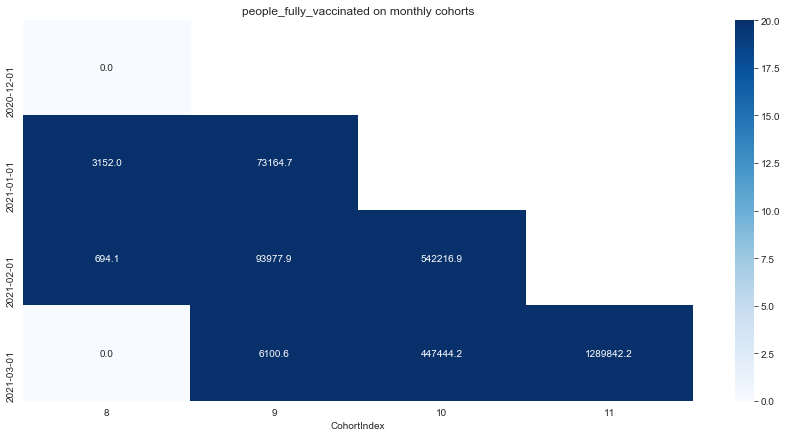

In [124]:
#mean quantity on cohorts

grouping = vax.groupby(['VaxedMonth', 'CohortIndex'])
cohort_data = grouping['people_fully_vaccinated'].mean()
cohort_data=cohort_data.reset_index()
avg_q=cohort_data.pivot(index='VaxedMonth', columns='CohortIndex', values='people_fully_vaccinated')
avg_q.round(1)
avg_q.index=avg_q.index.date

plt.figure(figsize=(15,7))
plt.title('people_fully_vaccinated on monthly cohorts')
sns.heatmap(data=avg_q, annot=True, vmin=0.0,  fmt = '.1f', vmax=20, cmap='Blues')
plt.show()


First 15 world countries that have fully vaccinated their people 

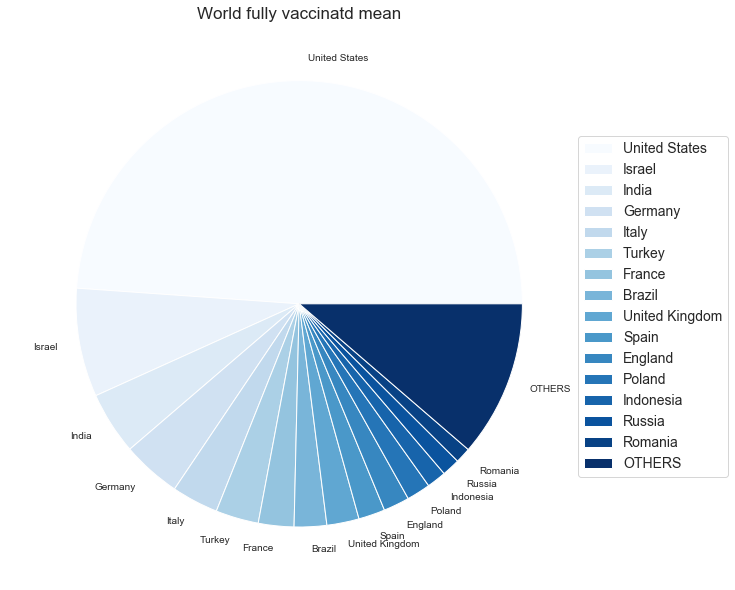

In [125]:
sns.set_style("whitegrid")
df = vax.groupby('country').agg({'people_fully_vaccinated': 'sum'}).sort_values('people_fully_vaccinated', ascending=False)

OTHERS = df.iloc[15:].sum()
df.drop(df.iloc[15:].index.tolist(), inplace=True)
df.loc['OTHERS'] = OTHERS


ax = df.plot.pie(y='people_fully_vaccinated', figsize=(10,20), colormap='Blues')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1.0, 0.8), loc=2, borderaxespad=0., fontsize=14)
plt.ylabel(' ')
plt.title('World fully vaccinatd mean', fontsize=17)
plt.show()

Vaccines

Distribution vaccines

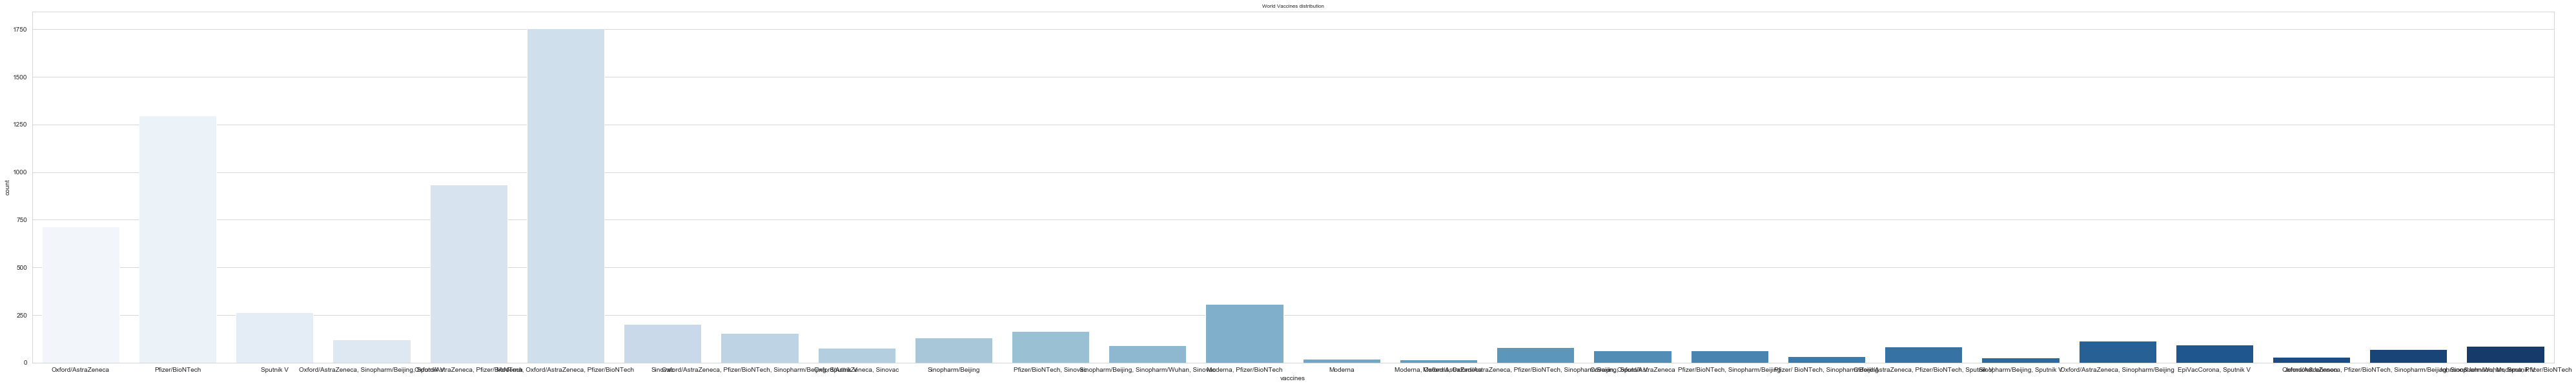

In [126]:
# distribution bar

plt.rcParams['figure.figsize'] = (70, 10)
sns.countplot(vax['vaccines'], palette = 'Blues')
plt.title('World Vaccines distribution', fontsize = 8)
plt.show()

In [149]:
v=vax.groupby(['vaccines'])['people_fully_vaccinated'].mean()
days=pd.DataFrame(data=v)
vaccination_bar=days.sort_values(by='people_fully_vaccinated',ascending=False,axis=0)
print(vaccination_bar)

fig = px.bar(vaccination_bar, x="people_fully_vaccinated", y=vaccination_bar.index, color='people_fully_vaccinated',color_continuous_scale='Blues',title="Vaccine order")
#plotly.offline.plot(fig, filename='v')

                                                    people_fully_vaccinated
vaccines                                                                   
Johnson&Johnson, Moderna, Pfizer/BioNTech                       11197725.19
Covaxin, Oxford/AstraZeneca                                      1475471.18
Oxford/AstraZeneca, Sinovac                                       623594.75
Moderna, Pfizer/BioNTech                                          572626.30
Sinovac                                                           448293.33
EpiVacCorona, Sputnik V                                           282690.15
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                      224027.03
Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V                    170237.26
Oxford/AstraZeneca, Sinopharm/Beijing                             129987.05
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, S...                127482.40
Pfizer/BioNTech, Sinovac                                          124993.64
Oxford/Astra

'v.html'

In [163]:
#contingency no.of.jobs table 
Germany=vax[vax.country=='Germany']

hourly=['iso_code', 'vaccines']
cm=sns.colormap='Blues'
pd.crosstab(Germany[hourly[0]], Germany[hourly[1]], values=Germany['people_fully_vaccinated'], margins=False, aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)

vaccines,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
iso_code,
DEU,86226307


In [162]:
#contingency no.of.jobs table 

hourly=['iso_code', 'vaccines']
cm=sns.colormap='Blues'
pd.crosstab(Romania[hourly[0]], Romania[hourly[1]], values=Romania['people_fully_vaccinated'], margins=False, aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)

vaccines,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
iso_code,
ROU,22634382


Clustering

In [143]:
vax_paths='vaccs_cluster.csv'
vacc=pd.read_csv(vax_paths)
print(vacc)

          country iso_code  total_vaccinations  people_vaccinated  \
0     Afghanistan      AFG                   0                  0   
1     Afghanistan      AFG                   0                  0   
2     Afghanistan      AFG                   0                  0   
3     Afghanistan      AFG                   0                  0   
4     Afghanistan      AFG                   0                  0   
...           ...      ...                 ...                ...   
6993     Zimbabwe      ZWE               36359              36359   
6994     Zimbabwe      ZWE               36359              36359   
6995     Zimbabwe      ZWE               37660              37660   
6996     Zimbabwe      ZWE               39550              39550   
6997     Zimbabwe      ZWE               39607              39607   

      people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
0                           0                       0                   0   
1                

In [151]:
x = vacc.iloc[:, [4, 2]].values
print(x.shape)

(6998, 2)


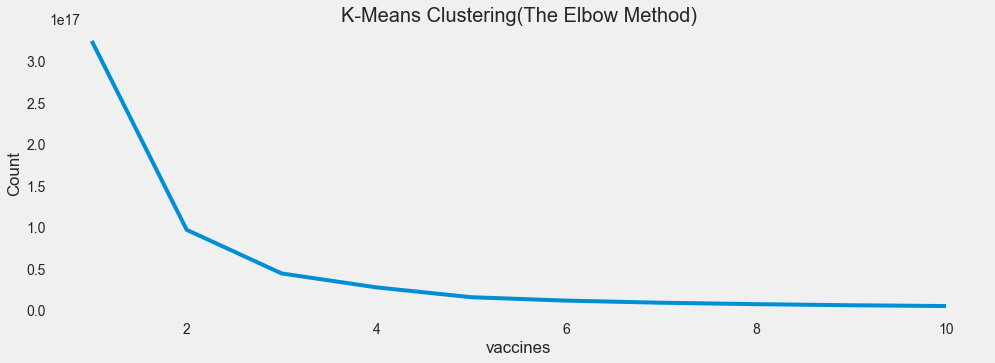

In [152]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(range(1, 11), wcss)
plt.title('K-Means Clustering(The Elbow Method)', fontsize = 20)
plt.xlabel('vaccines')
plt.ylabel('Count')
plt.grid()
plt.show()

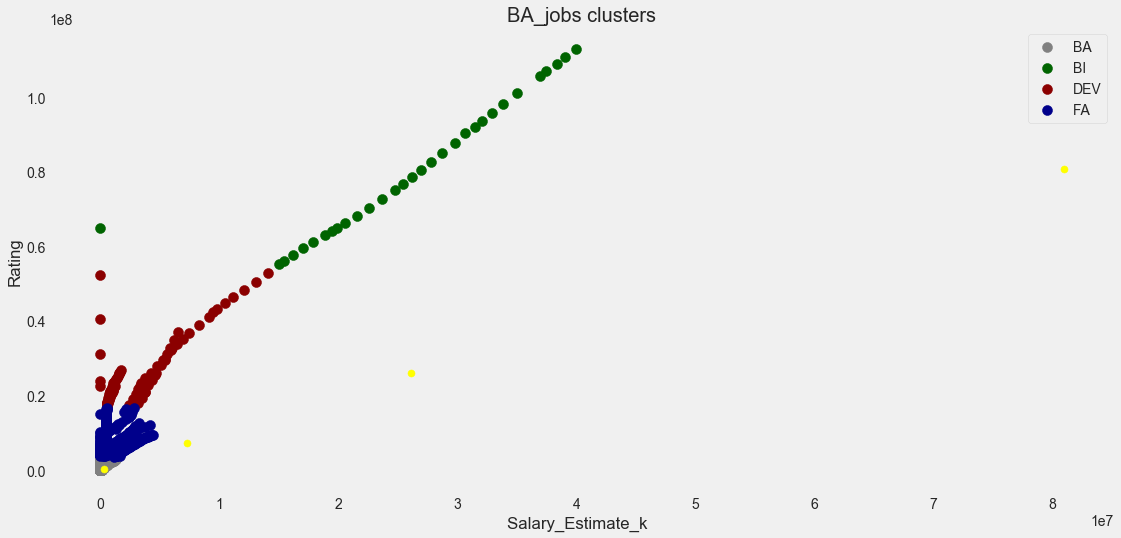

In [153]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
ymeans = kmeans.fit_predict(x)

plt.rcParams['figure.figsize'] = (17, 8)
plt.title('BA_jobs clusters', fontsize = 20)

plt.scatter(x[ymeans == 0, 0], x[ymeans == 0, 1], s = 100, c= 'gray', label = 'BA' )
plt.scatter(x[ymeans == 1, 0], x[ymeans == 1, 1], s = 100, c= 'darkgreen', label = 'BI')
plt.scatter(x[ymeans == 2, 0], x[ymeans == 2, 1], s = 100, c= 'darkred', label = 'DEV')
plt.scatter(x[ymeans == 3, 0], x[ymeans == 3, 1], s = 100, c = 'darkblue', label = 'FA')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 1], s = 50, c = 'yellow')

plt.style.use('fivethirtyeight')
plt.xlabel('Salary_Estimate_k  ')
plt.ylabel('Rating')
plt.legend()
plt.grid()

Fully vaccinated people's distribution accross world countries

<ipython-input-78-f38446b3974c>:2: RuntimeWarning: divide by zero encountered in log
  ax = np.log(Romania.pivot(index='date', columns='iso_code', values='people_fully_vaccinated')).plot(figsize=(14,7), colormap='Blues', linewidth=2)


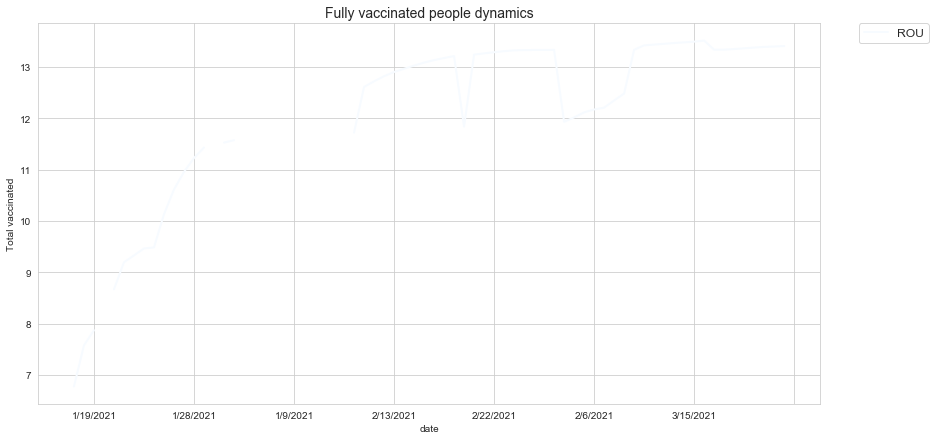

In [78]:
sns.set_style("whitegrid")
ax = np.log(Romania.pivot(index='date', columns='iso_code', values='people_fully_vaccinated')).plot(figsize=(14,7), colormap='Blues', linewidth=2)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.title('Fully vaccinated people dynamics', fontsize=14)
plt.ylabel('Total vaccinated')
plt.grid(which='minor')
plt.show()

